In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as st
from toolz import partition

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


#### 13.4 Data Generation

In [2]:
np.random.seed(5480)
x = np.repeat(['grassland', 'arable'], 10)
idx = pd.factorize(x)[0]
λ = np.exp(0.69 + 0.92 * idx)
C = np.random.poisson(λ)

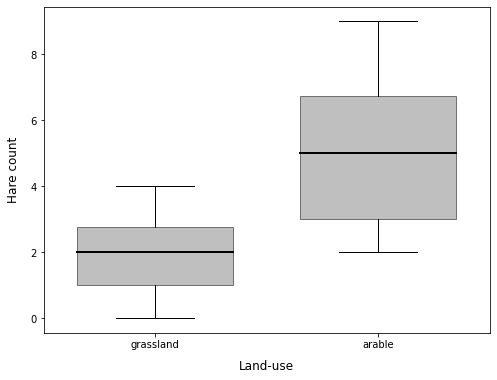

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
bxplot = ax.boxplot(list(partition(10, C)), 
                    widths = 0.7, 
                    boxprops = dict(facecolor = 'gray', alpha = 0.5),
                    medianprops = dict(linestyle='-', linewidth=2, color='black'),
                    patch_artist=True, 
                    labels = ['grassland', 'arable'])
ax.set_xlabel('Land-use', fontsize = 12, labelpad = 10)
ax.set_ylabel('Hare count', fontsize = 12, labelpad = 10);

In [4]:
with pm.Model() as model_13_5:
    alpha = pm.Normal('alpha', 0, tau = 0.001)
    beta = pm.Normal('beta', 0, tau = 0.001)
    λ = pm.Deterministic('λ', pm.math.exp(alpha + beta * idx))
    C_pred = pm.Poisson('C_pred', λ, observed = C)
    Presi = pm.Deterministic('Presi', (C_pred - λ) / pm.math.sqrt(λ))
    fit = pm.Deterministic('fit', pm.math.sum(pm.math.sqr(Presi)))
    
    trace_13_5 = pm.sample(4000, tune = 2000, target_accept = 0.95, return_inferencedata = True) 
    
    y_new = pm.sample_posterior_predictive(trace_13_5)
    data_aux = az.from_pymc3(posterior_predictive = y_new)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]


Sampling 2 chains for 2_000 tune and 4_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.


In [5]:
trace_13_5.extend(data_aux)

In [6]:
az.summary(trace_13_5, var_names = ['alpha', 'beta', 'fit'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.669,0.237,0.206,1.094,0.005,0.004,2159.0,2053.0,1.0
beta,0.910,0.282,0.406,1.475,0.006,0.005,2121.0,1938.0,1.0
fit,21.279,4.152,17.218,28.713,0.084,0.062,3308.0,2932.0,1.0


#### 13.5.1 Residuals

In [7]:
λ_post = trace_13_5.posterior.stack(samples = {'chain', 'draw'})['λ'].values
C_ppc = trace_13_5.posterior_predictive.stack(samples = {'chain', 'draw'})['C_pred'].values
fit_post = trace_13_5.posterior.stack(samples = {'chain', 'draw'})['fit'].values
Presi = trace_13_5.posterior.stack(samples = {'chain', 'draw'})['Presi'].values

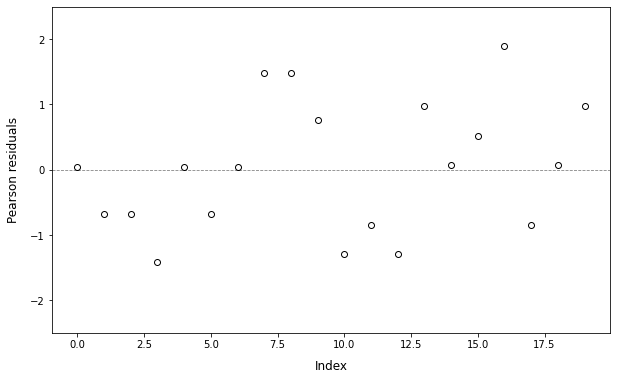

In [8]:
plt.figure(figsize = (10,6))
plt.axhline(y = 0, xmin = 0, xmax = 18, ls = '--', color = 'k', alpha = 0.5, lw = 0.8)
plt.scatter(range(20), Presi.mean(axis = 1), edgecolor = 'k', facecolor = 'white')
plt.ylim(-2.5, 2.5)
plt.xlabel('Index', fontsize = 12, labelpad = 10)
plt.ylabel('Pearson residuals', fontsize = 12, labelpad = 10);

#### 13.5.2 Inference under the model

In [17]:
Presi_new = (C_ppc - λ_post) / np.sqrt(λ_post)
fit_new = np.sum((Presi_new**2).mean(axis = 1))
#print(fit_new)
bpvalue = np.mean((Presi_new**2).sum(axis = 0) > fit_post)
print('Bayesian p-value =', bpvalue)

Bayesian p-value = 0.40425


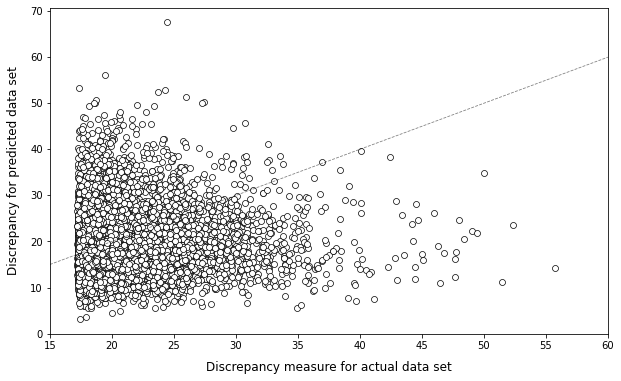

In [16]:
plt.figure(figsize = (10,6))
plt.axline((14, 14), ls = '--', color = 'k', slope=1, alpha = 0.5, lw = 0.8)
plt.scatter(fit_post, (Presi_new**2).sum(axis = 0), edgecolor = 'k', facecolor = 'white', lw = 0.7)
plt.xlim(15, 60)
plt.xlabel('Discrepancy measure for actual data set', fontsize = 12, labelpad = 10)
plt.ylabel('Discrepancy for predicted data set', fontsize = 12, labelpad = 10);

**FIGURE 13.5**

In [12]:
beta = trace_13_5.posterior.stack(samples = {'chain', 'draw'})['beta'].values
alpha = trace_13_5.posterior.stack(samples = {'chain', 'draw'})['alpha'].values

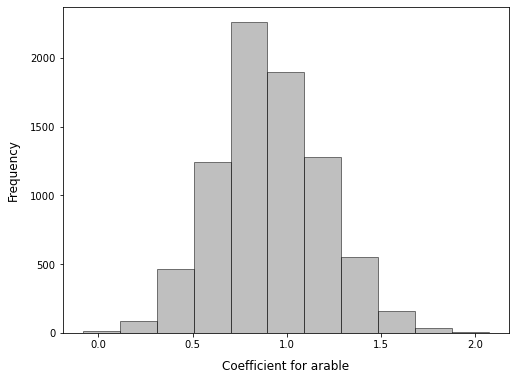

In [13]:
plt.figure(figsize = (8, 6))
plt.hist(beta, bins = 11, color= 'gray', edgecolor='black', alpha = 0.5)
plt.xlabel('Coefficient for arable', fontsize = 12, labelpad = 10)
plt.ylabel('Frequency', fontsize = 12, labelpad = 10);

**FIGURE 13.6**

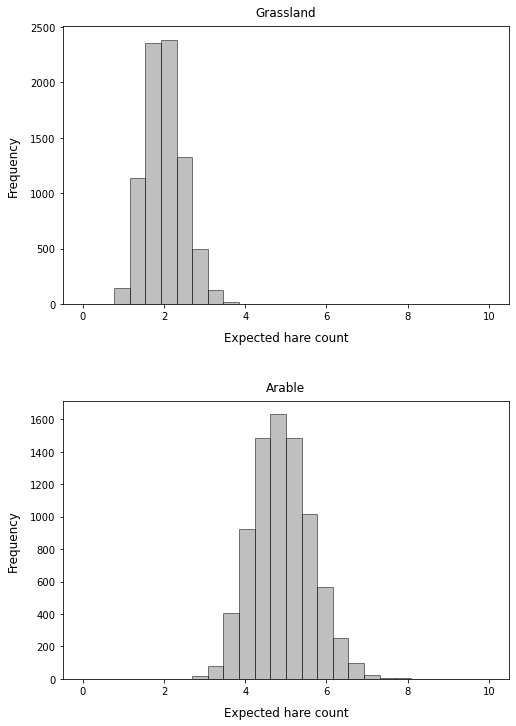

In [14]:
fig, ax = plt.subplots(2,1,figsize=(8,12), gridspec_kw={'hspace': 0.35})
ax[0].hist(np.exp(alpha), bins = 26, range = [0, 10], color= 'gray', edgecolor='black', alpha = 0.5)
ax[0].set_title('Grassland', fontsize = 12, pad = 10)
ax[0].set_xlabel('Expected hare count', fontsize = 12, labelpad = 10)
ax[0].set_ylabel('Frequency', fontsize = 12, labelpad = 10)
ax[1].hist(np.exp(alpha + beta), bins = 26, range = [0, 10], color= 'gray', edgecolor='black', alpha = 0.5)
ax[1].set_title('Arable', fontsize = 12, pad = 10)
ax[1].set_xlabel('Expected hare count', fontsize = 12, labelpad = 10)
ax[1].set_ylabel('Frequency', fontsize = 12, labelpad = 10);